In [1]:
import os
from datetime import datetime
# Make logging folder named according to current time
start_time_str = datetime.today().strftime('%d_%m_%Y__%H_%M_%S')
log_dir = './logs/'f"log_{start_time_str}"
os.makedirs(log_dir)

# Initialize logger that adds to text file in current logging folder
from logging_utils import *


# Initialize logger that adds to text file in current logging folder
from logging_utils import *
init_logger(save_dir=log_dir)
logger = get_logger()

In [2]:
import pathlib
import subprocess
# Get the absolute path to your repository, 
# no matter where you are running this code from

repo_path = os.getcwd() 


git_branch = subprocess.check_output(
    ["git", "-C", repo_path, "rev-parse", "--abbrev-ref", "HEAD"]).strip().decode('UTF-8')

git_commit_short_hash = subprocess.check_output(
    ["git", "-C", repo_path, "describe", "--always"]).strip().decode('UTF-8')


In [3]:
from src_dir import *
import numpy as np

dim=125
x0=np.squeeze(np.zeros((dim,1)))
x0Type='Zero Vector'

# FD_StencilMat=np.zeros((dim,dim))
# b = np.ones(dim-1)
# c = -2*np.ones(dim)
# np.fill_diagonal(FD_StencilMat[1:], b)
# np.fill_diagonal(FD_StencilMat[:,1:], b)
# np.fill_diagonal(FD_StencilMat, c)
# A=FD_StencilMat
# A=np.asmatrix(A)
A=mk_laplace_1d(dim)
AType='1D Laplacian'

retrain_freq=1
e1 = 1e-4
e2 = 1e-7
nmax_iter = 50
restart   = 64

sigma=0.02
DomainL=-5.0
DomainR=5.0
x=np.linspace(DomainL,DomainR,dim)



n_steps =2000
InputDim=dim
HiddenDim=dim
OutputDim=dim

In [4]:
# Initial log message
logger.info("Benchmark 125 dim problem. Linear gradient RHS. Test 1D linop. Benchmark on Kevin's PC.")
#  The source is a narrow gaussian that depends on the integer 'time' in a nonlinear way. The gaussian is on the interval [-5,5], and constrained to move on [-3,3]. ")



# Set up parameter class
class MyParamsClass():
    def __init__(self, AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash):
        self.AType = AType
        self.dim = dim
        self.nmax_iter = nmax_iter
        self.restart = restart
        self.n_steps =n_steps
        self.retrain_freq=retrain_freq
        self.e1=e1
        self.e2=e2
        self.x0Type=x0Type
        self.InputDim=InputDim
        self.HiddenDim=HiddenDim
        self.OutputDim=OutputDim
        self.sigma=sigma
        self.DomainL=DomainL
        self.DomainR=DomainR
        self.git_branch=git_branch
        self.git_commit_short_hash=git_commit_short_hash





import os
import json

params = MyParamsClass(AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash)
sorted_params_dict = {k: params.__dict__[k] for k 
                      in sorted(params.__dict__.keys())}

params_filepath = log_dir+'/params.json'
json.dump(sorted_params_dict, open(params_filepath, 'w'), indent=4)

2020-06-11 22:15:50 [INFO] <ipython-input-4-44a99f37ffba> 2 - Benchmark 125 dim problem. Linear gradient RHS. Test 1D linop. Benchmark on Kevin's PC.


In [5]:
from src_dir import *

# @nn_preconditioner(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,HiddenDim2=HiddenDim2,OutputDim=OutputDim)
# def MLGMRES(A, b, x0, e, nmax_iter,IterErr0_sum,IterErr0,ProbCount,Add,restart,debug):
#     return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
@cnn_preconditionerOnline_timed(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,OutputDim=OutputDim)
def MLGMRES(A, b, x0, e, nmax_iter,ML_GMRES_Time_list,ProbCount,restart,debug,refine,blist,reslist,Err_list):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
def GMRES_timed(A, b, x0, e, nmax_iter,restart,debug):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)

In [6]:
from src_dir import *



ML_GMRES_Time_list=[]

Err_list=[]
NonML_Err_List=[]

run_time_ML_list=[]
run_timeP1_ML_list=[]
run_timeP2_ML_list=[]

run_time_list=[]
GmresRunTimeOriginal=[]
GmresRunTimeOriginal2=[]

trainTime_list=[]


debug=True
refine1=False
refine2=True

blist=[]
reslist=[]



for ProbIdx in range(n_steps):

    loc=4*np.sin(0.5*ProbIdx*np.abs(np.cos(0.5*ProbIdx)))
#     b=Gauss_pdf(x,loc,sigma)
    b=(np.sin(ProbIdx)+.0001)*np.maximum(x-loc,0)
    b_norm=np.linalg.norm(b)



    OutList1,run_time1_ML=MLGMRES(A, b/b_norm, x0, e1, nmax_iter,ML_GMRES_Time_list,ProbIdx,restart,debug,refine1,blist,reslist,Err_list)  # normalize b for optimal NN performance.
    Out=OutList1[0]
    ML_GMRES_Time_list=OutList1[1]
    blist=OutList1[3]
    reslist=OutList1[4]
    Err_list=OutList1[5]

    OutList2,run_time2_ML=MLGMRES(A, b/b_norm, Out[-1], e2, nmax_iter,ML_GMRES_Time_list,ProbIdx,restart,debug,refine2,blist,reslist,Err_list)
    Out2=OutList2[0]
    ML_GMRES_Time_list=OutList2[1]
    trainTime_list.append(OutList2[2])
    blist=OutList2[3]
    reslist=OutList2[4]
    Err_list=OutList2[5]

    run_timeP1_ML_list.append(run_time1_ML)
    run_timeP2_ML_list.append(run_time2_ML)
    run_time_ML_list.append(run_time1_ML+run_time2_ML)
    



    NonML_Out1,run_time1=GMRES_timed(A, b/b_norm, x0, e1, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    NonML_Err=resid(A, NonML_Out1, b/b_norm)
    NonML_Err_List.append(NonML_Err[50])
   
    NonML_Out2,run_time2=GMRES_timed(A, b/b_norm, NonML_Out1[-1], e2, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    
    GmresRunTimeOriginal.append(run_time1)
    GmresRunTimeOriginal2.append(run_time2)
    run_time_list.append(run_time1+run_time2)
    
    print(ProbIdx)


run_time=sum(run_time_list)
run_time_ML=sum(run_time_ML_list)
trainTime_total=sum(trainTime_list)


logger.info("Runtime of Non-decorated version is:")
logger.info(run_time)

logger.info("Runtime of MLGMRES decorator is:")
logger.info(run_time_ML)


logger.info("Runtime of training (backprop) is:")
logger.info(trainTime_total)



0
1
Final loss: 6378.5732421875
parameters 31250
Initial Training
2
size 52
0.023087805928347298 0.3367121113433218
0.5180973319802433 0.7386481654975796 0.023087805928347298 0.22228070966830848
0.5180973319802433 0.7386481654975796 0.023087805928347298 0.22228070966830848
3
size 52
0.06401921960021824 0.3367121113433218
0.3881776249909308 0.7134383149823407 0.06401921960021824 0.11662119197300364
0.3881776249909308 0.7134383149823407 0.06401921960021824 0.11662119197300364
4
size 52
0.02903871274400665 0.3367121113433218
0.31124007800826803 0.605018084985204 0.02903871274400665 0.09908720118207516
0.31124007800826803 0.605018084985204 0.02903871274400665 0.09908720118207516
5
size 52
0.1692003809942119 0.3367121113433218
0.6709722760133445 0.40583834499314736 0.1692003809942119 0.03871524609085739
0.6709722760133445 0.40583834499314736 0.1692003809942119 0.03871524609085739
6
size 52
0.05202101609882409 0.3367121113433218
0.3798486129962839 0.47212182774819667 0.05202101609882409 0.07

0.28600450200610794 0.3827426542004105 0.025545705085988968 0.06904026416191504
39
size 52
0.062250424965630935 0.3367121113433218
0.37051698297727853 0.3775638598401565 0.062250424965630935 0.0639496612967943
0.37051698297727853 0.3775638598401565 0.062250424965630935 0.0639496612967943
40
size 52
0.07327819124088053 0.3367121113433218
0.518487138004275 0.38154224931960923 0.07327819124088053 0.06617820806995202
0.518487138004275 0.38154224931960923 0.07327819124088053 0.06617820806995202
41
size 52
0.03310937543492017 0.3367121113433218
0.2805808569828514 0.38203146671992727 0.03310937543492017 0.0661405222622175
0.2805808569828514 0.38203146671992727 0.03310937543492017 0.0661405222622175
42
size 52
0.019494033708504725 0.3367121113433218
0.29126913100481033 0.3768140824791044 0.019494033708504725 0.05919205968989389
0.29126913100481033 0.3768140824791044 0.019494033708504725 0.05919205968989389
43
size 52
0.034757435836800445 0.3367121113433218
0.3480508560023736 0.3734813118400052

Final loss: 1714.0887451171875
parameters 31250
76
size 52
0.06006158079876903 0.3367121113433218
0.345976165990578 0.2930089791212231 0.06006158079876903 0.020215112108219392
0.345976165990578 0.2930089791212231 0.06006158079876903 0.020215112108219392
77
size 52
0.003998535828179015 0.3367121113433218
0.2739572659775149 0.2948941244801972 0.003998535828179015 0.021819603101125063
0.2739572659775149 0.2948941244801972 0.003998535828179015 0.021819603101125063
78
size 52
0.01978339487396371 0.3367121113433218
0.2825897560105659 0.2992560035991482 0.01978339487396371 0.021579968422157175
0.2825897560105659 0.2992560035991482 0.01978339487396371 0.021579968422157175
79
size 52
0.0005175091779811176 0.3367121113433218
0.08597973300493322 0.30400486815953626 0.0005175091779811176 0.02191447135563645
0.08597973300493322 0.30400486815953626 0.0005175091779811176 0.02191447135563645
80
size 52
0.021388506367901183 0.3367121113433218
0.3513130969949998 0.2975856082804967 0.021388506367901183 0

Final loss: 1094.50244140625
parameters 31250
113
size 52
0.004088932572475469 0.3367121113433218
0.2464266869938001 0.24606636235839688 0.004088932572475469 0.015540367562802688
0.2464266869938001 0.24606636235839688 0.004088932572475469 0.015540367562802688
114
size 52
0.003589356722902425 0.3367121113433218
0.20568192898645066 0.24213810027809812 0.003589356722902425 0.01467731690050744
0.20568192898645066 0.24213810027809812 0.003589356722902425 0.01467731690050744
115
size 52
0.005689060560395615 0.3367121113433218
0.20027624399517663 0.2389726925571449 0.005689060560395615 0.014259376614934018
0.20027624399517663 0.2389726925571449 0.005689060560395615 0.014259376614934018
116
size 52
0.009872811492567895 0.3367121113433218
0.24696034099906683 0.24190847283694894 0.009872811492567895 0.013740533005275073
0.24696034099906683 0.24190847283694894 0.009872811492567895 0.013740533005275073
117
size 52
0.0010493689998110553 0.3367121113433218
0.08143451999058016 0.24193342827726155 0.0

0.29334319598274305 0.22651047999854199 0.006702838435638573 0.008167041548314487
0.29334319598274305 0.22651047999854199 0.006702838435638573 0.008167041548314487
150
size 52
0.01729132541528598 0.3367121113433218
0.2655042400001548 0.2285657398379408 0.01729132541528598 0.007549826793849677
0.2655042400001548 0.2285657398379408 0.01729132541528598 0.007549826793849677
151
size 52
0.015006776858899756 0.3367121113433218
0.22969213902251795 0.22942024711868725 0.015006776858899756 0.007868419111331213
0.22969213902251795 0.22942024711868725 0.015006776858899756 0.007868419111331213
InnerProd [[1.         0.99995255 0.99943618]
 [0.99995255 1.         0.99971538]
 [0.99943618 0.99971538 1.        ]]
retraining
1
Final loss: 668.525146484375
parameters 31250
152
size 52
0.0031071689339136634 0.3367121113433218
0.1517219160159584 0.22486560376011766 0.0031071689339136634 0.0077323937276790235
0.1517219160159584 0.22486560376011766 0.0031071689339136634 0.0077323937276790235
153
size 52
0.

0.1484486179833766 0.18655371659551748 0.0014426416261756497 0.003624835947096427
186
size 52
0.004059120853352103 0.3367121113433218
0.2036132070061285 0.18404628879507073 0.004059120853352103 0.0035936820324194256
0.2036132070061285 0.18404628879507073 0.004059120853352103 0.0035936820324194256
InnerProd [[ 1.          0.99319019 -0.95324702]
 [ 0.99319019  1.         -0.97882961]
 [-0.95324702 -0.97882961  1.        ]]
retraining
1
Final loss: 321.29754638671875
parameters 31250
187
size 52
0.0046751474679017305 0.3367121113433218
0.2958053009933792 0.18428170719533227 0.0046751474679017305 0.003672966085151642
0.2958053009933792 0.18428170719533227 0.0046751474679017305 0.003672966085151642
188
size 52
0.007510817916414399 0.3367121113433218
0.19786239598761313 0.19011584055493586 0.007510817916414399 0.0037780736435803096
0.19786239598761313 0.19011584055493586 0.007510817916414399 0.0037780736435803096
189
size 52
0.005511427718505447 0.3367121113433218
0.29503438199753873 0.1930

220
size 52
0.0031831205058900705 0.3367121113433218
0.29761569798574783 0.19737959904130548 0.0031831205058900705 0.003088847319743399
0.29761569798574783 0.19737959904130548 0.0031831205058900705 0.003088847319743399
221
size 52
0.004612973176265968 0.3367121113433218
0.1504991170077119 0.2047977768012788 0.004612973176265968 0.003070880986860941
0.1504991170077119 0.2047977768012788 0.004612973176265968 0.003070880986860941
222
size 52
0.00407708767080947 0.3367121113433218
0.22482429500087164 0.2048239459609613 0.00407708767080947 0.003154330735327338
0.22482429500087164 0.2048239459609613 0.00407708767080947 0.003154330735327338
InnerProd [[ 1.         -0.9942714  -0.99697896]
 [-0.9942714   1.          0.9995508 ]
 [-0.99697896  0.9995508   1.        ]]
retraining
1
Final loss: 231.01976013183594
parameters 31250
223
size 52
0.002457678381553766 0.3367121113433218
0.14290609801537357 0.20743160148034803 0.002457678381553766 0.003256128849847628
0.14290609801537357 0.2074316014803

0.08073551501729526 0.17886451783590018 0.00039610350825068023 0.003385771090459372
257
size 52
0.000990917612853561 0.3367121113433218
0.12366344698239118 0.17605978087638505 0.000990917612853561 0.0031150562006680566
0.12366344698239118 0.17605978087638505 0.000990917612853561 0.0031150562006680566
258
size 52
0.0027824194003573883 0.3367121113433218
0.16436265598167665 0.17336068599601276 0.0027824194003573883 0.0028895208547959567
0.16436265598167665 0.17336068599601276 0.0027824194003573883 0.0028895208547959567
259
size 52
0.00511912226917369 0.3367121113433218
0.248519866989227 0.16999174463562666 0.00511912226917369 0.0028247272923220107
0.248519866989227 0.16999174463562666 0.00511912226917369 0.0028247272923220107
InnerProd [[ 1.         -0.99975164 -0.9985524 ]
 [-0.99975164  1.          0.99950031]
 [-0.9985524   0.99950031  1.        ]]
retraining
1
Final loss: 242.67532348632812
parameters 31250
260
size 52
0.0033160938486678586 0.3367121113433218
0.1506627879862208 0.173

0.19827641200390644 0.16412641123635693 0.002329016206631138 0.002620526717933516
293
size 52
0.004084527613212063 0.3367121113433218
0.1624333109939471 0.16447238059714436 0.004084527613212063 0.002606177173966186
0.1624333109939471 0.16447238059714436 0.004084527613212063 0.002606177173966186
294
size 52
0.003047298171975716 0.3367121113433218
0.1637904919916764 0.16488078971626238 0.003047298171975716 0.0027149902323630117
0.1637904919916764 0.16488078971626238 0.003047298171975716 0.0027149902323630117
295
size 52
0.0017238298665261567 0.3367121113433218
0.16471976999309845 0.16342417215579189 0.0017238298665261567 0.002746604254383345
0.16471976999309845 0.16342417215579189 0.0017238298665261567 0.002746604254383345
296
size 52
0.002674481002837418 0.3367121113433218
0.19687958198483102 0.16545693835592828 0.002674481002837418 0.0027343213476440776
0.19687958198483102 0.16545693835592828 0.002674481002837418 0.0027343213476440776
297
size 52
0.002869358947727011 0.3367121113433218

0.17169408398331143 0.16886563656036743 0.0016713475255239027 0.002259424870655899
329
size 52
0.0010308439158329369 0.3367121113433218
0.10052435399848036 0.16777082287939266 0.0010308439158329369 0.002219597481844025
0.10052435399848036 0.16777082287939266 0.0010308439158329369 0.002219597481844025
330
size 52
0.0010415901777689487 0.3367121113433218
0.14968598398263566 0.1668973700387869 0.0010415901777689487 0.0022228412314144984
0.14968598398263566 0.1668973700387869 0.0010415901777689487 0.0022228412314144984
331
size 52
0.0011064081102144495 0.3367121113433218
0.12816821099841036 0.16633900867775084 0.0011064081102144495 0.002181693884351606
0.12816821099841036 0.16633900867775084 0.0011064081102144495 0.002181693884351606
332
size 52
0.0016121568818996846 0.3367121113433218
0.21400368001195602 0.16554966163705104 0.0016121568818996846 0.0021702507675330305
0.21400368001195602 0.16554966163705104 0.0016121568818996846 0.0021702507675330305
333
size 52
0.0020468057405944556 0.336

0.1501582830096595 0.1617456983565353 0.0022478643787721448 0.002068302434960653
365
size 52
0.002457537802350016 0.3367121113433218
0.19936222900287248 0.16200865111663007 0.002457537802350016 0.002071411966424476
0.19936222900287248 0.16200865111663007 0.002457537802350016 0.002071411966424476
366
size 52
0.0013808158531940138 0.3367121113433218
0.12498860302730463 0.16397494551725686 0.0013808158531940138 0.002053713865953518
0.12498860302730463 0.16397494551725686 0.0013808158531940138 0.002053713865953518
367
size 52
0.0011455611998859069 0.3367121113433218
0.12642812001286075 0.16447624275810085 0.0011455611998859069 0.0020485249808394885
0.12642812001286075 0.16447624275810085 0.0011455611998859069 0.0020485249808394885
368
size 52
0.001254667585161331 0.3367121113433218
0.1515354019938968 0.1615449154796079 0.001254667585161331 0.002019562672104971
0.1515354019938968 0.1615449154796079 0.001254667585161331 0.002019562672104971
369
size 52
0.0016371342735719524 0.336712111343321

0.2032290670031216 0.15744971416075715 0.0027047871981706367 0.0018865236322397117
InnerProd [[ 1.          0.89591121 -0.92073133]
 [ 0.89591121  1.         -0.99639752]
 [-0.92073133 -0.99639752  1.        ]]
retraining
1
Final loss: 180.89678955078125
parameters 31250
402
size 52
0.0009798342999881202 0.3367121113433218
0.11456693700165488 0.157598296480719 0.0009798342999881202 0.00192505190413612
0.11456693700165488 0.157598296480719 0.0009798342999881202 0.00192505190413612
403
size 52
0.0030862719016571693 0.3367121113433218
0.15329799000755884 0.1571573751210235 0.0030862719016571693 0.00189902178010495
0.15329799000755884 0.1571573751210235 0.0030862719016571693 0.00189902178010495
404
size 52
0.0019951612673216033 0.3367121113433218
0.13941045899991877 0.1599244339216966 0.0019951612673216033 0.0019385932165173056
0.13941045899991877 0.1599244339216966 0.0019951612673216033 0.0019385932165173056
405
size 52
0.0014603268204440043 0.3367121113433218
0.19660754699725658 0.157577

0.12056871200911701 0.13927703519817441 0.0010039320624661704 0.0017464039405152493
438
size 52
0.0017469747130940327 0.3367121113433218
0.20372937998035923 0.13618765607941896 0.0017469747130940327 0.0017407183866502396
0.20372937998035923 0.13618765607941896 0.0017469747130940327 0.0017407183866502396
439
size 52
0.0015611269505536273 0.3367121113433218
0.11790438700700179 0.1381610870384611 0.0015611269505536273 0.0017492762480786114
0.11790438700700179 0.1381610870384611 0.0015611269505536273 0.0017492762480786114
440
size 52
0.00197758322333827 0.3367121113433218
0.14967866300139576 0.13823855895898304 0.00197758322333827 0.0017615672482976293
0.14967866300139576 0.13823855895898304 0.00197758322333827 0.0017615672482976293
441
size 52
0.0019115392056687339 0.3367121113433218
0.11790281799039803 0.1382516119990032 0.0019115392056687339 0.0017645526479628533
0.11790281799039803 0.1382516119990032 0.0019115392056687339 0.0017645526479628533
442
size 52
0.0016098538207563863 0.336712

0.1670811729854904 0.15563451916561463 0.0021240244278337463 0.0014015161616960658
473
size 52
0.001058632558319355 0.3367121113433218
0.0846958110050764 0.1562924115243368 0.001058632558319355 0.0013524461398014425
0.0846958110050764 0.1562924115243368 0.001058632558319355 0.0013524461398014425
474
size 52
0.00135774455424971 0.3367121113433218
0.16862063700682484 0.15456051564426163 0.00135774455424971 0.001344554852142511
0.16862063700682484 0.15456051564426163 0.00135774455424971 0.001344554852142511
475
size 52
0.0011007586049544258 0.3367121113433218
0.15105943600065075 0.15527232336462476 0.0011007586049544258 0.0013572780862523093
0.15105943600065075 0.15527232336462476 0.0011007586049544258 0.0013572780862523093
476
size 52
0.0015747950528830874 0.3367121113433218
0.22348472400335595 0.15135701604420318 0.0015747950528830874 0.0013051890989818342
0.22348472400335595 0.15135701604420318 0.0015747950528830874 0.0013051890989818342
InnerProd [[ 1.         -0.99985937 -0.99173972]

0.15567050699610263 0.14807561483583412 0.0009567466700474805 0.0016310655935481996
508
size 52
0.0016168888105982946 0.3367121113433218
0.1988731900055427 0.14920960955554619 0.0016168888105982946 0.0016254517745909738
0.1988731900055427 0.14920960955554619 0.0016168888105982946 0.0016254517745909738
509
size 52
0.0015403292540861074 0.3367121113433218
0.19139106801594608 0.1520253924757708 0.0015403292540861074 0.0016170574071180256
0.19139106801594608 0.1520253924757708 0.0015403292540861074 0.0016170574071180256
510
size 52
0.0034617949782410357 0.3367121113433218
0.12832216901006177 0.15180625695735217 0.0034617949782410357 0.0015225417908994287
0.12832216901006177 0.15180625695735217 0.0034617949782410357 0.0015225417908994287
511
size 52
0.0019178183288935324 0.3367121113433218
0.14878139999927953 0.1539421741978731 0.0019178183288935324 0.0016145939041202636
0.14878139999927953 0.1539421741978731 0.0019178183288935324 0.0016145939041202636
512
size 52
0.0008859206522725107 0.33

0.15222779000760056 0.1452857284003403 0.0010440658712399834 0.001489925118995769
544
size 52
0.0017821122704408372 0.3367121113433218
0.1923565419856459 0.1414983827609103 0.0017821122704408372 0.001454865248098025
0.1923565419856459 0.1414983827609103 0.0017821122704408372 0.001454865248098025
InnerProd [[ 1.          0.92683678 -0.91807597]
 [ 0.92683678  1.         -0.99952517]
 [-0.91807597 -0.99952517  1.        ]]
retraining
1
Final loss: 146.02191162109375
parameters 31250
545
size 52
0.0006433998098794879 0.3367121113433218
0.08786707400577143 0.14416200408013538 0.0006433998098794879 0.0014759571171343883
0.08786707400577143 0.14416200408013538 0.0006433998098794879 0.0014759571171343883
546
size 52
0.0013737562073970957 0.3367121113433218
0.08797870099078864 0.142649658160517 0.0013737562073970957 0.0014475124700988058
0.08797870099078864 0.142649658160517 0.0013737562073970957 0.0014475124700988058
547
size 52
0.000990670583364628 0.3367121113433218
0.14941467801691033 0.14

0.1555612570082303 0.1333304943202529 0.0011781702749687577 0.0010856310488763393
579
size 52
0.0023796692704326538 0.3367121113433218
0.19602356100222096 0.13561017088009975 0.0023796692704326538 0.0010737968892152296
0.19602356100222096 0.13561017088009975 0.0023796692704326538 0.0010737968892152296
InnerProd [[1.         0.94816149 0.9293076 ]
 [0.94816149 1.         0.99732759]
 [0.9293076  0.99732759 1.        ]]
retraining
1
Final loss: 132.35015869140625
parameters 31250
580
size 52
0.0013021347064789148 0.3367121113433218
0.12496113398810849 0.1394873730407562 0.0013021347064789148 0.0011427807806343292
0.12496113398810849 0.1394873730407562 0.0013021347064789148 0.0011427807806343292
581
size 52
0.0013226164851044121 0.3367121113433218
0.12640210398240015 0.1410564412001986 0.0013226164851044121 0.0011687387809004432
0.12640210398240015 0.1410564412001986 0.0013226164851044121 0.0011687387809004432
582
size 52
0.001070157524409568 0.3367121113433218
0.19784781298949383 0.13756

613
size 52
0.0010591476047289352 0.3367121113433218
0.15092846000334248 0.15143376732245087 0.0010591476047289352 0.001233311813474091
0.15092846000334248 0.15143376732245087 0.0010591476047289352 0.001233311813474091
614
size 52
0.0006498101309188897 0.3367121113433218
0.15061031901859678 0.1534954850829672 0.0006498101309188897 0.001247690259388712
0.15061031901859678 0.1534954850829672 0.0006498101309188897 0.001247690259388712
615
size 52
0.0014516356714264125 0.3367121113433218
0.1143852419918403 0.15554100544308314 0.0014516356714264125 0.0012620305901145782
0.1143852419918403 0.15554100544308314 0.0014516356714264125 0.0012620305901145782
616
size 52
0.0016582364109335463 0.3367121113433218
0.11432828399119899 0.15513249712297694 0.0016582364109335463 0.001261134376435125
0.11432828399119899 0.15513249712297694 0.0016582364109335463 0.001261134376435125
617
size 52
0.0012569501545910762 0.3367121113433218
0.1504326570138801 0.15470846440293826 0.0012569501545910762 0.0012683983

649
size 52
0.0010064534332480655 0.3367121113433218
0.19926404501893558 0.1323847606824711 0.0010064534332480655 0.0010100428444453496
0.19926404501893558 0.1323847606824711 0.0010064534332480655 0.0010100428444453496
650
size 52
0.001494759827756253 0.3367121113433218
0.16650139799457975 0.13439801684231498 0.001494759827756253 0.0010325795511987848
0.16650139799457975 0.13439801684231498 0.001494759827756253 0.0010325795511987848
InnerProd [[ 1.         -0.99782825  0.99829127]
 [-0.99782825  1.         -0.99241795]
 [ 0.99829127 -0.99241795  1.        ]]
retraining
1
Final loss: 106.3782958984375
parameters 31250
651
size 52
0.0004329960870324516 0.3367121113433218
0.09946487098932266 0.1335446730419062 0.0004329960870324516 0.0010249916907001334
0.09946487098932266 0.1335446730419062 0.0004329960870324516 0.0010249916907001334
652
size 52
0.0009734972098854211 0.3367121113433218
0.15138949701213278 0.13445031816139819 0.0009734972098854211 0.0010243158744959644
0.15138949701213278

685
size 52
0.0009796097866430246 0.3367121113433218
0.11539958699722774 0.11889052219572477 0.0009796097866430246 0.0007698046737450933
0.11539958699722774 0.11889052219572477 0.0009796097866430246 0.0007698046737450933
686
size 52
0.000828722498217862 0.3367121113433218
0.09903228998882696 0.11836292355554179 0.000828722498217862 0.0007779498436946482
0.09903228998882696 0.11836292355554179 0.000828722498217862 0.0007779498436946482
687
size 52
0.000784309498119193 0.3367121113433218
0.07742331500048749 0.11833646307466551 0.000784309498119193 0.0007767487027322252
0.07742331500048749 0.11833646307466551 0.000784309498119193 0.0007767487027322252
688
size 52
0.000514881304451115 0.3367121113433218
0.11677293400862254 0.11746745159500278 0.000514881304451115 0.0007877304550766915
0.11677293400862254 0.11746745159500278 0.000514881304451115 0.0007877304550766915
689
size 52
0.0004625209274194219 0.3367121113433218
0.1485167740029283 0.11702841487596743 0.0004625209274194219 0.000768568

720
size 52
0.0005956039463450816 0.3367121113433218
0.08379219399648719 0.12150414287811145 0.0005956039463450816 0.0007714053263753526
0.08379219399648719 0.12150414287811145 0.0005956039463450816 0.0007714053263753526
721
size 52
0.0008372904919501031 0.3367121113433218
0.1488854680210352 0.12021930863847956 0.0008372904919501031 0.0007612541155469478
0.1488854680210352 0.12021930863847956 0.0008372904919501031 0.0007612541155469478
722
size 52
0.0006770754187245637 0.3367121113433218
0.10116562800249085 0.12152815439971164 0.0006770754187245637 0.0007614618956979759
0.10116562800249085 0.12152815439971164 0.0006770754187245637 0.0007614618956979759
723
size 52
0.0008585969094203392 0.3367121113433218
0.12155612799688242 0.12159086936037056 0.0008585969094203392 0.0007608403472358905
0.12155612799688242 0.12159086936037056 0.0008585969094203392 0.0007608403472358905
724
size 52
0.0009246720942449536 0.3367121113433218
0.1664512110000942 0.12192377711995504 0.0009246720942449536 0.00

755
size 52
0.0007651262947481734 0.3367121113433218
0.14855569301289506 0.10797412059968338 0.0007651262947481734 0.0007091437785525362
0.14855569301289506 0.10797412059968338 0.0007651262947481734 0.0007091437785525362
756
size 52
0.0011748472151654646 0.3367121113433218
0.07770421600434929 0.10794543999945745 0.0011748472151654646 0.0006814685366728362
0.07770421600434929 0.10794543999945745 0.0011748472151654646 0.0006814685366728362
757
size 52
0.0006090662946167823 0.3367121113433218
0.07808882801327854 0.10665828324039467 0.0006090662946167823 0.0007065508954560777
0.07808882801327854 0.10665828324039467 0.0006090662946167823 0.0007065508954560777
758
size 52
0.00028200394269973876 0.3367121113433218
0.09922161098802462 0.10649300580145792 0.00028200394269973876 0.0007068755157880731
0.09922161098802462 0.10649300580145792 0.00028200394269973876 0.0007068755157880731
759
size 52
0.0003235338983813238 0.3367121113433218
0.09928246701019816 0.10547327052103356 0.000323533898381323

0.09969726699637249 0.11319159627892077 0.0003708157836022066 0.0008336872170316358
791
size 52
0.00029618730357103214 0.3367121113433218
0.09970216601504944 0.1131688099191524 0.00029618730357103214 0.0008364723546264679
0.09970216601504944 0.1131688099191524 0.00029618730357103214 0.0008364723546264679
792
size 52
0.0007282330908278303 0.3367121113433218
0.07625464900047518 0.10920276447897777 0.0007282330908278303 0.0008201259701143786
0.07625464900047518 0.10920276447897777 0.0007282330908278303 0.0008201259701143786
793
size 52
0.00022792887385234936 0.3367121113433218
0.07608242801507004 0.10878383015864529 0.00022792887385234936 0.000815155354383013
0.07608242801507004 0.10878383015864529 0.00022792887385234936 0.000815155354383013
794
size 52
0.0006316155211421905 0.3367121113433218
0.077323798002908 0.10779719371930696 0.0006316155211421905 0.000805411069777222
0.077323798002908 0.10779719371930696 0.0006316155211421905 0.000805411069777222
795
size 52
0.0005382902710570198 0.

0.07864729498396628 0.11059974751784467 0.0012234524043230244 0.0007174107538758634
826
size 52
0.0004224109856151137 0.3367121113433218
0.10034281900152564 0.11064253059681504 0.0004224109856151137 0.0007410195610733895
0.10034281900152564 0.11064253059681504 0.0004224109856151137 0.0007410195610733895
827
size 52
0.00017238121425241034 0.3367121113433218
0.07909416398615576 0.11154923771740868 0.00017238121425241034 0.0007379953008994848
0.07909416398615576 0.11154923771740868 0.00017238121425241034 0.0007379953008994848
828
size 52
0.0003036545665027363 0.3367121113433218
0.07912076500360854 0.11077486487687566 0.0003036545665027363 0.0007283054539891245
0.07912076500360854 0.11077486487687566 0.0003036545665027363 0.0007283054539891245
829
size 52
0.001398187596254475 0.3367121113433218
0.12717789399903268 0.10794130407623015 0.001398187596254475 0.0007151440709500415
0.12717789399903268 0.10794130407623015 0.001398187596254475 0.0007151440709500415
830
size 52
0.001047731467710206

0.08425571900443174 0.12403901492245495 0.00028703358149191 0.0007255738387783024
861
size 52
0.0007214484143115693 0.3367121113433218
0.08428885400644504 0.12270720976288431 0.0007214484143115693 0.0006734924579808534
0.08428885400644504 0.12270720976288431 0.0007214484143115693 0.0006734924579808534
862
size 52
0.0008775084218283463 0.3367121113433218
0.2004922420019284 0.12208550520241261 0.0008775084218283463 0.0006714164103445416
0.2004922420019284 0.12208550520241261 0.0008775084218283463 0.0006714164103445416
863
size 52
0.0004774206618056873 0.3367121113433218
0.08288499398622662 0.12616117412224412 0.0004774206618056873 0.0006799069721427424
0.08288499398622662 0.12616117412224412 0.0004774206618056873 0.0006799069721427424
864
size 52
0.0004104910947189549 0.3367121113433218
0.08419040398439392 0.12260409672162495 0.0004104910947189549 0.0006723505310651975
0.08419040398439392 0.12260409672162495 0.0004104910947189549 0.0006723505310651975
865
size 52
0.0007187877326601366 0.

0.09831044197198935 0.1198997645219788 0.0004248735747055251 0.000805087050027934
0.09831044197198935 0.1198997645219788 0.0004248735747055251 0.000805087050027934
896
size 52
0.0004854564195924923 0.3367121113433218
0.07751347700832412 0.12041140343993902 0.0004854564195924923 0.0008101026625630104
0.07751347700832412 0.12041140343993902 0.0004854564195924923 0.0008101026625630104
897
size 52
0.0008862113768717152 0.3367121113433218
0.11590879899449646 0.11757693724008277 0.0008862113768717152 0.000810433745737519
0.11590879899449646 0.11757693724008277 0.0008862113768717152 0.000810433745737519
898
size 52
0.00043725799044461687 0.3367121113433218
0.07803292002063245 0.11825565183884464 0.00043725799044461687 0.0008305299874006772
0.07803292002063245 0.11825565183884464 0.00043725799044461687 0.0008305299874006772
899
size 52
0.0008516509967006434 0.3367121113433218
0.09897829598048702 0.11455774387926794 0.0008516509967006434 0.000818150277479876
0.09897829598048702 0.11455774387926

931
size 52
0.0001191973064128353 0.3367121113433218
0.05002983898157254 0.1040122735593468 0.0001191973064128353 0.0006219182610066828
0.05002983898157254 0.1040122735593468 0.0001191973064128353 0.0006219182610066828
932
size 52
0.0014552360724623618 0.3367121113433218
0.14868702000239864 0.10008414087933488 0.0014552360724623618 0.0006007537329135123
0.14868702000239864 0.10008414087933488 0.0014552360724623618 0.0006007537329135123
InnerProd [[ 1.         -0.99882604 -0.99572176]
 [-0.99882604  1.          0.99900876]
 [-0.99572176  0.99900876  1.        ]]
retraining
1
Final loss: 6.699698448181152
parameters 31250
933
size 52
0.00045780328552441857 0.3367121113433218
0.08479910501046106 0.10292332475888542 0.00045780328552441857 0.0006405175564916749
0.08479910501046106 0.10292332475888542 0.00045780328552441857 0.0006405175564916749
934
size 52
0.00028207817527204563 0.3367121113433218
0.086427051021019 0.10318176467902958 0.00028207817527204563 0.0006513059826397764
0.086427051

0.10047348600346595 0.11014381399843842 0.0002666286016596834 0.000500912393978281
966
size 52
0.00042196630745290294 0.3367121113433218
0.16864991298643872 0.11077140235924161 0.00042196630745290294 0.0004923530923579767
0.16864991298643872 0.11077140235924161 0.00042196630745290294 0.0004923530923579767
967
size 52
0.001215764227192036 0.3367121113433218
0.12385122798150405 0.11412525115883909 0.001215764227192036 0.0005031506266885056
0.12385122798150405 0.11412525115883909 0.001215764227192036 0.0005031506266885056
968
size 52
0.00033741345180419546 0.3367121113433218
0.10106994601665065 0.11506316759856418 0.00033741345180419546 0.0005302632331368483
0.10106994601665065 0.11506316759856418 0.00033741345180419546 0.0005302632331368483
969
size 52
0.00030393622041559315 0.3367121113433218
0.10022535402094945 0.11511614519986324 0.00030393622041559315 0.0005297968410071363
0.10022535402094945 0.11511614519986324 0.00030393622041559315 0.0005297968410071363
970
size 52
0.0005422251290

Final loss: 8.276355743408203
parameters 31250
1001
size 52
0.00043660459976651184 0.3367121113433218
0.07813934001023881 0.11071020119939931 0.00043660459976651184 0.00048515991064546147
0.07813934001023881 0.11071020119939931 0.00043660459976651184 0.00048515991064546147
1002
size 52
0.0002574095326066874 0.3367121113433218
0.10010893701110035 0.11086105667985975 0.0002574095326066874 0.0004789937390793774
0.10010893701110035 0.11086105667985975 0.0002574095326066874 0.0004789937390793774
1003
size 52
0.00026800366340755784 0.3367121113433218
0.09216189899598248 0.1102453408006113 0.00026800366340755784 0.00047439677523961624
0.09216189899598248 0.1102453408006113 0.00026800366340755784 0.00047439677523961624
1004
size 52
0.00041672290762621747 0.3367121113433218
0.08419702298124321 0.11073192071984522 0.00041672290762621747 0.00047750097090228544
0.08419702298124321 0.11073192071984522 0.00041672290762621747 0.00047750097090228544
1005
size 52
0.0003435643470990098 0.336712111343321

0.10801182501018047 0.11300843368167988 0.00022728062700329768 0.0006874960956440331
0.10801182501018047 0.11300843368167988 0.00022728062700329768 0.0006874960956440331
1036
size 52
0.0009474255604955485 0.3367121113433218
0.0802801109966822 0.11108697528252379 0.0009474255604955485 0.000672798126451538
0.0802801109966822 0.11108697528252379 0.0009474255604955485 0.000672798126451538
1037
size 52
0.00036474628487262613 0.3367121113433218
0.08049125800607726 0.11068358356249519 0.00036474628487262613 0.0006793744158191292
0.08049125800607726 0.11068358356249519 0.00036474628487262613 0.0006793744158191292
1038
size 52
0.0008818936267639844 0.3367121113433218
0.1001817200158257 0.10970912720309571 0.0008818936267639844 0.0006784358505076737
0.1001817200158257 0.10970912720309571 0.0008818936267639844 0.0006784358505076737
1039
size 52
0.0005721390395886862 0.3367121113433218
0.16101644199807197 0.10766172496369109 0.0005721390395886862 0.0006666009959320018
0.16101644199807197 0.1076617

0.0917366259964183 0.10652074671932496 0.0002661494561151619 0.0005156215439037794
1072
size 52
0.0003217979906962782 0.3367121113433218
0.0925489479850512 0.1061076648789458 0.0003217979906962782 0.0005088516108243121
0.0925489479850512 0.1061076648789458 0.0003217979906962782 0.0005088516108243121
1073
size 52
0.0003447629187244959 0.3367121113433218
0.10296989299240522 0.10667348607792519 0.0003447629187244959 0.000499923725605974
0.10296989299240522 0.10667348607792519 0.0003447629187244959 0.000499923725605974
1074
size 52
0.0003866789379972825 0.3367121113433218
0.11088484499487095 0.10763668867759407 0.0003866789379972825 0.000495441718986554
0.11088484499487095 0.10763668867759407 0.0003866789379972825 0.000495441718986554
1075
size 52
0.00028966378466485247 0.3367121113433218
0.07707116199890152 0.10892175403772854 0.00028966378466485247 0.0004871767267015471
0.07707116199890152 0.10892175403772854 0.00028966378466485247 0.0004871767267015471
1076
size 52
0.0007099302005447866

1107
size 52
0.0009040879209804227 0.3367121113433218
0.07833862697589211 0.11195972456363962 0.0009040879209804227 0.0005409654165979556
0.07833862697589211 0.11195972456363962 0.0009040879209804227 0.0005409654165979556
1108
size 52
0.0002675254984523953 0.3367121113433218
0.08037182700354606 0.10824608696275391 0.0002675254984523953 0.000528568814447222
0.08037182700354606 0.10824608696275391 0.0002675254984523953 0.000528568814447222
1109
size 52
0.000415103433598469 0.3367121113433218
0.11576896900078282 0.10508325040340423 0.000415103433598469 0.0005236403481057504
0.11576896900078282 0.10508325040340423 0.000415103433598469 0.0005236403481057504
1110
size 52
0.0001265470505776513 0.3367121113433218
0.05212808900978416 0.10572581528336741 0.0001265470505776513 0.0005281372548995088
0.05212808900978416 0.10572581528336741 0.0001265470505776513 0.0005281372548995088
1111
size 52
0.000206570200707919 0.3367121113433218
0.08234118999098428 0.10270093076280318 0.000206570200707919 0.0

0.09731753298547119 0.1016851674823556 0.0002266144201650805 0.0004587019692209473
0.09731753298547119 0.1016851674823556 0.0002266144201650805 0.0004587019692209473
1143
size 52
0.0007941196780876129 0.3367121113433218
0.10546252300264314 0.10157945928163827 0.0007941196780876129 0.0004591705155920027
0.10546252300264314 0.10157945928163827 0.0007941196780876129 0.0004591705155920027
1144
size 52
0.0005902965826669139 0.3367121113433218
0.10629578601219691 0.10228500532219187 0.0005902965826669139 0.00047424750907640355
0.10629578601219691 0.10228500532219187 0.0005902965826669139 0.00047424750907640355
1145
size 52
0.0003916038857295192 0.3367121113433218
0.07976562599651515 0.10246319804224185 0.0003916038857295192 0.0004813704136157828
0.07976562599651515 0.10246319804224185 0.0003916038857295192 0.0004813704136157828
1146
size 52
0.0004049614058830422 0.3367121113433218
0.07946276501752436 0.10168118492234499 0.0004049614058830422 0.00048066789976884656
0.07946276501752436 0.10168

0.12023584300186485 0.0991691179596819 0.0006522702423628793 0.0005021060921104285
1178
size 52
0.0001819335241345112 0.3367121113433218
0.08444567900733091 0.10059504660079256 0.0001819335241345112 0.0005143423305194702
0.08444567900733091 0.10059504660079256 0.0001819335241345112 0.0005143423305194702
1179
size 52
0.0004948308443044111 0.3367121113433218
0.09998038999037817 0.10063343768008054 0.0004948308443044111 0.0005119396517515716
0.09998038999037817 0.10063343768008054 0.0004948308443044111 0.0005119396517515716
1180
size 52
0.0002895306450648532 0.3367121113433218
0.10011413699248806 0.09744451508042402 0.0002895306450648532 0.00048322271454693345
0.10011413699248806 0.09744451508042402 0.0002895306450648532 0.00048322271454693345
1181
size 52
0.0004033532166572692 0.3367121113433218
0.08306894800625741 0.09742530616000294 0.0004033532166572692 0.00047795216207202097
0.08306894800625741 0.09742530616000294 0.0004033532166572692 0.00047795216207202097
1182
size 52
0.0008185866

1212
size 52
0.00021837275235332272 0.3367121113433218
0.07737982500111684 0.10293326299986802 0.00021837275235332272 0.0006413482281433329
0.07737982500111684 0.10293326299986802 0.00021837275235332272 0.0006413482281433329
1213
size 52
0.0008653476119024464 0.3367121113433218
0.11655303800944239 0.10295712235965766 0.0008653476119024464 0.0006141693304570115
0.11655303800944239 0.10295712235965766 0.0008653476119024464 0.0006141693304570115
1214
size 52
0.0005759652387455789 0.3367121113433218
0.2110700490011368 0.10300448975991458 0.0005759652387455789 0.000613033171706916
0.2110700490011368 0.10300448975991458 0.0005759652387455789 0.000613033171706916
1215
size 52
0.00019677656184295198 0.3367121113433218
0.0798532179906033 0.10833943216013722 0.00019677656184295198 0.0005989832601157023
0.0798532179906033 0.10833943216013722 0.00019677656184295198 0.0005989832601157023
1216
size 52
0.00014902696657362598 0.3367121113433218
0.07862078701145947 0.10754182751988992 0.000149026966573

0.1038363859988749 0.10862455400056206 0.00030503739007738454 0.0005398263500302564
1248
size 52
0.0004024447070420907 0.3367121113433218
0.15137900598347187 0.1093430416006595 0.0004024447070420907 0.0005403306850422236
0.15137900598347187 0.1093430416006595 0.0004024447070420907 0.0005403306850422236
1249
size 52
0.00024781324585550343 0.3367121113433218
0.08253447699826211 0.11198985307943075 0.00024781324585550343 0.0005510877543295068
0.08253447699826211 0.11198985307943075 0.00024781324585550343 0.0005510877543295068
1250
size 52
0.0002759592982784279 0.3367121113433218
0.15090904000680894 0.11132357088034041 0.0002759592982784279 0.0005466102025502182
0.15090904000680894 0.11132357088034041 0.0002759592982784279 0.0005466102025502182
1251
size 52
0.0007986333237873122 0.3367121113433218
0.09939000700251199 0.11339222376001999 0.0007986333237873122 0.0005458534918832211
0.09939000700251199 0.11339222376001999 0.0007986333237873122 0.0005458534918832211
1252
size 52
0.000304866927

0.12362037601997145 0.09976339116110466 0.0012954278721334742 0.00048756409337043384
InnerProd [[1.         0.98319573 0.99999371]
 [0.98319573 1.         0.98259229]
 [0.99999371 0.98259229 1.        ]]
retraining
1
Final loss: 17.082412719726562
parameters 31250
1284
size 52
0.0005425141351191094 0.3367121113433218
0.09973870101384819 0.10043828076217323 0.0005425141351191094 0.0005259456083725315
0.09973870101384819 0.10043828076217323 0.0005425141351191094 0.0005259456083725315
1285
size 52
0.0005362779893796725 0.3367121113433218
0.07912037501228042 0.10098782596178353 0.0005362779893796725 0.0005329650811766041
0.07912037501228042 0.10098782596178353 0.0005362779893796725 0.0005329650811766041
1286
size 52
0.00022514162119973666 0.3367121113433218
0.07829707098426297 0.09921635424252599 0.00022514162119973666 0.000511768508953395
0.07829707098426297 0.09921635424252599 0.00022514162119973666 0.000511768508953395
1287
size 52
0.00041797525807501406 0.3367121113433218
0.08632587298

0.08029750399873592 0.1092810543999076 0.0002566179002792313 0.00048317680922953005
1319
size 52
0.0002003367139867053 0.3367121113433218
0.08175176099757664 0.1090680160804186 0.0002003367139867053 0.00047922901599989527
0.08175176099757664 0.1090680160804186 0.0002003367139867053 0.00047922901599989527
1320
size 52
0.00040172658139288493 0.3367121113433218
0.08194632298545912 0.10725040100049227 0.00040172658139288493 0.0004688898728547626
0.08194632298545912 0.10725040100049227 0.00040172658139288493 0.0004688898728547626
1321
size 52
0.0006841321775934363 0.3367121113433218
0.09929317701607943 0.10454691071994603 0.0006841321775934363 0.0004604441803770733
0.09929317701607943 0.10454691071994603 0.0006841321775934363 0.0004604441803770733
1322
size 52
0.0002006350353980169 0.3367121113433218
0.09848146300646476 0.10292095712036825 0.0002006350353980169 0.0004659602172887059
0.09848146300646476 0.10292095712036825 0.0002006350353980169 0.0004659602172887059
1323
size 52
0.0003241014

1355
size 52
0.0004007841243859426 0.3367121113433218
0.10073989399825223 0.1017948222369887 0.0004007841243859426 0.0004983896053012117
0.10073989399825223 0.1017948222369887 0.0004007841243859426 0.0004983896053012117
1356
size 52
0.0004173929576812141 0.3367121113433218
0.07359615300083533 0.1018389608769212 0.0004173929576812141 0.0004967493065212125
0.07359615300083533 0.1018389608769212 0.0004173929576812141 0.0004967493065212125
1357
size 52
0.0007648448559009897 0.3367121113433218
0.07766150101087987 0.10154158323653974 0.0007648448559009897 0.0004922687042618235
0.07766150101087987 0.10154158323653974 0.0007648448559009897 0.0004922687042618235
1358
size 52
0.0007365769091096551 0.3367121113433218
0.0776361069874838 0.10139258475624956 0.0007365769091096551 0.0005073980984488836
0.0776361069874838 0.10139258475624956 0.0007365769091096551 0.0005073980984488836
1359
size 52
0.0003572677399483353 0.3367121113433218
0.09835769500932656 0.10055882639600895 0.0003572677399483353 0.

1392
size 52
0.0002061352142406972 0.3367121113433218
0.08160997601225972 0.09256546599790454 0.0002061352142406972 0.0004322224381870344
0.08160997601225972 0.09256546599790454 0.0002061352142406972 0.0004322224381870344
1393
size 52
0.0001750308391370921 0.3367121113433218
0.08180445001926273 0.09187764139845968 0.0001750308391370921 0.0004233500118513153
0.08180445001926273 0.09187764139845968 0.0001750308391370921 0.0004233500118513153
1394
size 52
0.0006817046787207831 0.3367121113433218
0.09913288700045086 0.0934808385593351 0.0006817046787207831 0.00042597618637546075
0.09913288700045086 0.0934808385593351 0.0006817046787207831 0.00042597618637546075
1395
size 52
0.0007174110111281698 0.3367121113433218
0.08185156498802826 0.09247491963906214 0.0007174110111281698 0.0004376215485908591
0.08185156498802826 0.09247491963906214 0.0007174110111281698 0.0004376215485908591
1396
size 52
0.0005797983414960541 0.3367121113433218
0.08123544001136906 0.08975552359945141 0.0005797983414960

0.1966727639955934 0.09694642323767766 0.0016652874402710905 0.00041209174025537995
0.1966727639955934 0.09694642323767766 0.0016652874402710905 0.00041209174025537995
InnerProd [[ 1.         -0.99693756 -0.9997219 ]
 [-0.99693756  1.          0.99849128]
 [-0.9997219   0.99849128  1.        ]]
retraining
1
Final loss: 22.708454132080078
parameters 31250
1429
size 52
0.0007401889076947074 0.3367121113433218
0.07570781599497423 0.10086521831690334 0.0007401889076947074 0.00046554866875423676
0.07570781599497423 0.10086521831690334 0.0007401889076947074 0.00046554866875423676
1430
size 52
0.0001533227992482193 0.3367121113433218
0.07613141497131437 0.09991781071643345 0.0001533227992482193 0.00047895270807207124
0.07613141497131437 0.09991781071643345 0.0001533227992482193 0.00047895270807207124
1431
size 52
0.00038533876921519945 0.3367121113433218
0.14785572499386035 0.0995397719158791 0.00038533876921519945 0.0004652187275473179
0.14785572499386035 0.0995397719158791 0.000385338769215

0.08373372399364598 0.09101416120422073 0.00034412319980117387 0.00043210836490158795
1465
size 52
0.00044209538528938323 0.3367121113433218
0.09963683600653894 0.09039924596319907 0.00044209538528938323 0.00043161655520010557
0.09963683600653894 0.09039924596319907 0.00044209538528938323 0.00043161655520010557
1466
size 52
0.0006561480847206039 0.3367121113433218
0.09959155198885128 0.08990412676357665 0.0006561480847206039 0.00043051363545951166
0.09959155198885128 0.08990412676357665 0.0006561480847206039 0.00043051363545951166
1467
size 52
0.0004466222127213857 0.3367121113433218
0.09947972500231117 0.09082023952389136 0.0004466222127213857 0.00043334293468952833
0.09947972500231117 0.09082023952389136 0.0004466222127213857 0.00043334293468952833
1468
size 52
0.0002700185436293186 0.3367121113433218
0.08408581998082809 0.091681629603263 0.0002700185436293186 0.0004410806611710161
0.08408581998082809 0.091681629603263 0.0002700185436293186 0.0004410806611710161
1469
size 52
0.000307

0.08306313698994927 0.09634698671870864 0.0003503168616549277 0.0004433848955336974
1501
size 52
0.0005003180037815375 0.3367121113433218
0.14847292099148035 0.09635897491825744 0.0005003180037815375 0.0004359925921787515
0.14847292099148035 0.09635897491825744 0.0005003180037815375 0.0004359925921787515
1502
size 52
0.0013915631177197378 0.3367121113433218
0.16613459601649083 0.0983349834778346 0.0013915631177197378 0.00043920147836320935
0.16613459601649083 0.0983349834778346 0.0013915631177197378 0.00043920147836320935
1503
size 52
0.0006835663953665157 0.3367121113433218
0.08310364402132109 0.09903182863956317 0.0006835663953665157 0.00046718396011022746
0.08310364402132109 0.09903182863956317 0.0006835663953665157 0.00046718396011022746
1504
size 52
0.0005010002636265587 0.3367121113433218
0.10014926199801266 0.09909269060008227 0.0005010002636265587 0.0004807136808030731
0.10014926199801266 0.09909269060008227 0.0005010002636265587 0.0004807136808030731
1505
size 52
0.00094539274

1536
size 52
0.0005489007284971978 0.3367121113433218
0.08307047400739975 0.10082009272067807 0.0005489007284971978 0.00048524943307218867
0.08307047400739975 0.10082009272067807 0.0005489007284971978 0.00048524943307218867
1537
size 52
0.00021629145207737466 0.3367121113433218
0.09924572799354792 0.09816114876186476 0.00021629145207737466 0.0004918322319852854
0.09924572799354792 0.09816114876186476 0.00021629145207737466 0.0004918322319852854
1538
size 52
0.00033702789837200986 0.3367121113433218
0.09930844500195235 0.09879475520108827 0.00033702789837200986 0.0004867884586389348
0.09930844500195235 0.09879475520108827 0.00033702789837200986 0.0004867884586389348
1539
size 52
0.00044178037650459954 0.3367121113433218
0.08255662900046445 0.09943434252054431 0.00044178037650459954 0.0004797052847680895
0.08255662900046445 0.09943434252054431 0.00044178037650459954 0.0004797052847680895
1540
size 52
0.0007269806843084259 0.3367121113433218
0.09929004401783459 0.09939746584161185 0.00072

1572
size 52
0.0006222429184076195 0.3367121113433218
0.0827612380089704 0.09799180692061782 0.0006222429184076195 0.00045984134785118807
0.0827612380089704 0.09799180692061782 0.0006222429184076195 0.00045984134785118807
1573
size 52
0.0003164376411680573 0.3367121113433218
0.09889249899424613 0.09801112184184603 0.0003164376411680573 0.0004787107815023864
0.09889249899424613 0.09801112184184603 0.0003164376411680573 0.0004787107815023864
1574
size 52
0.0003447940137013206 0.3367121113433218
0.1355039729969576 0.09796769432141446 0.0003447940137013206 0.00046790729348491296
0.1355039729969576 0.09796769432141446 0.0003447940137013206 0.00046790729348491296
1575
size 52
0.00039990680161561666 0.3367121113433218
0.08268495099036954 0.0994111794012133 0.00039990680161561666 0.000472600396213191
0.08268495099036954 0.0994111794012133 0.00039990680161561666 0.000472600396213191
1576
size 52
0.0002972306615102133 0.3367121113433218
0.08316297299461439 0.09950751540018246 0.00029723066151021

1608
size 52
0.0007939731602243016 0.3367121113433218
0.16437201801454648 0.09727386852260679 0.0007939731602243016 0.0004329545960437189
0.16437201801454648 0.09727386852260679 0.0007939731602243016 0.0004329545960437189
InnerProd [[1.         0.99601498 0.99910185]
 [0.99601498 1.         0.99887919]
 [0.99910185 0.99887919 1.        ]]
retraining
1
Final loss: 19.023630142211914
parameters 31250
1609
size 52
0.0007164214044227216 0.3367121113433218
0.15073925800970756 0.09987855272251181 0.0007164214044227216 0.00044918832593910177
0.15073925800970756 0.09987855272251181 0.0007164214044227216 0.00044918832593910177
1610
size 52
0.0003499348962311214 0.3367121113433218
0.07478418000391684 0.10263478708220646 0.0003499348962311214 0.00046236827827746374
0.07478418000391684 0.10263478708220646 0.0003499348962311214 0.00046236827827746374
1611
size 52
0.0004749259774781549 0.3367121113433218
0.07513544999528676 0.1007070492033381 0.0004749259774781549 0.0004570192164835339
0.07513544999

0.08607232800568454 0.08452163519570605 0.00025570726326532993 0.000498031250104944
1644
size 52
0.0003929560092412163 0.3367121113433218
0.0999500020116102 0.08492029559682124 0.0003929560092412163 0.0004976196701050517
0.0999500020116102 0.08492029559682124 0.0003929560092412163 0.0004976196701050517
1645
size 52
0.0002554932580361772 0.3367121113433218
0.0996834609832149 0.08587766891694627 0.0002554932580361772 0.0004939021121947067
0.0996834609832149 0.08587766891694627 0.0002554932580361772 0.0004939021121947067
1646
size 52
0.0005610799439915315 0.3367121113433218
0.08471484601614065 0.08682203915552236 0.0005610799439915315 0.0004950276100788941
0.08471484601614065 0.08682203915552236 0.0005610799439915315 0.0004950276100788941
1647
size 52
0.0002365068410256732 0.3367121113433218
0.09979203200782649 0.08624659899622202 0.0002365068410256732 0.0005049021662779076
0.09979203200782649 0.08624659899622202 0.0002365068410256732 0.0005049021662779076
1648
size 52
0.00013830029950515

0.12383537599816918 0.09924096011905931 0.0008582481565497549 0.0004238624548353319
1681
size 52
0.00036560743312333315 0.3367121113433218
0.09906622799462639 0.10022355879889801 0.00036560743312333315 0.000451567168515653
0.09906622799462639 0.10022355879889801 0.00036560743312333315 0.000451567168515653
1682
size 52
0.00031605987831277146 0.3367121113433218
0.09929738799110055 0.09838121687876993 0.00031605987831277146 0.00043471324586451856
0.09929738799110055 0.09838121687876993 0.00031605987831277146 0.00043471324586451856
1683
size 52
0.0003863085259881392 0.3367121113433218
0.08253990797675215 0.09901019947836176 0.0003863085259881392 0.0004387895347144357
0.08253990797675215 0.09901019947836176 0.0003863085259881392 0.0004387895347144357
1684
size 52
0.00015277983565799757 0.3367121113433218
0.0988359940238297 0.0963052439573221 0.00015277983565799757 0.00043748553939646244
0.0988359940238297 0.0963052439573221 0.00015277983565799757 0.00043748553939646244
1685
size 52
0.000362

1716
size 52
0.0005084880098976112 0.3367121113433218
0.0830691909941379 0.09665160208474845 0.0005084880098976112 0.0003413069745205842
0.0830691909941379 0.09665160208474845 0.0005084880098976112 0.0003413069745205842
1717
size 52
0.0004839796356651466 0.3367121113433218
0.09936101699713618 0.09398048032540827 0.0004839796356651466 0.0003435092521289194
0.09936101699713618 0.09398048032540827 0.0004839796356651466 0.0003435092521289194
1718
size 52
0.0004525531718237972 0.3367121113433218
0.09984805301064625 0.0947951108054258 0.0004525531718237972 0.00035449412983341996
0.09984805301064625 0.0947951108054258 0.0004525531718237972 0.00035449412983341996
1719
size 52
0.0002818624032339522 0.3367121113433218
0.0753731039876584 0.09549965236568823 0.0002818624032339522 0.00035558691803895206
0.0753731039876584 0.09549965236568823 0.0002818624032339522 0.00035558691803895206
1720
size 52
0.0005617475716473884 0.3367121113433218
0.14891891600564122 0.09517719264491462 0.000561747571647388

1752
size 52
0.00025820363413374625 0.3367121113433218
0.0776706530014053 0.09002692859736271 0.00025820363413374625 0.0004059397290903637
0.0776706530014053 0.09002692859736271 0.00025820363413374625 0.0004059397290903637
1753
size 52
0.00041501218594109973 0.3367121113433218
0.07715758398990147 0.09005992971826345 0.00041501218594109973 0.00040377142800927975
0.07715758398990147 0.09005992971826345 0.00041501218594109973 0.00040377142800927975
1754
size 52
0.000951245380756148 0.3367121113433218
0.14792552398284897 0.08804963719798252 0.000951245380756148 0.0004052478673281374
0.14792552398284897 0.08804963719798252 0.000951245380756148 0.0004052478673281374
InnerProd [[1.         0.99971928 0.99240423]
 [0.99971928 1.         0.9949681 ]
 [0.99240423 0.9949681  1.        ]]
retraining
1
Final loss: 19.91514778137207
parameters 31250
1755
size 52
0.0004188717545651182 0.3367121113433218
0.12427134098834358 0.0908574358781334 0.0004188717545651182 0.0004290927163253906
0.1242713409883

1788
size 52
0.0009394453578813836 0.3367121113433218
0.1485860219981987 0.09315931219956837 0.0009394453578813836 0.0003668526157219094
0.1485860219981987 0.09315931219956837 0.0009394453578813836 0.0003668526157219094
InnerProd [[ 1.          0.99273188 -0.98682156]
 [ 0.99273188  1.         -0.99903699]
 [-0.98682156 -0.99903699  1.        ]]
retraining
1
Final loss: 20.3232421875
parameters 31250
1789
size 52
0.0002861351156261423 0.3367121113433218
0.0826139060081914 0.09576937559875659 0.0002861351156261423 0.0003940744468519163
0.0826139060081914 0.09576937559875659 0.0002861351156261423 0.0003940744468519163
1790
size 52
0.0003584051464239289 0.3367121113433218
0.12315987297915854 0.09706282179802656 0.0003584051464239289 0.0004032949621212717
0.12315987297915854 0.09706282179802656 0.0003584051464239289 0.0004032949621212717
1791
size 52
0.0006047652360884381 0.3367121113433218
0.09928288499941118 0.09803398763760925 0.0006047652360884381 0.00039943581935537057
0.0992828849994

0.07453485499718226 0.09811446228297427 0.0004023447338971688 0.0003989551096232018
1824
size 52
0.000668737360355844 0.3367121113433218
0.07437774198479019 0.09714663324295543 0.000668737360355844 0.00040239164287037314
0.07437774198479019 0.09714663324295543 0.000668737360355844 0.00040239164287037314
1825
size 52
0.0003581503859271346 0.3367121113433218
0.098761014000047 0.0941482945624739 0.0003581503859271346 0.00041162030098608216
0.098761014000047 0.0941482945624739 0.0003581503859271346 0.00041162030098608216
1826
size 52
0.00032282512960654273 0.3367121113433218
0.07433912198757753 0.09481502476148307 0.00032282512960654273 0.000415733099041397
0.07433912198757753 0.09481502476148307 0.00032282512960654273 0.000415733099041397
1827
size 52
0.0002959470792065901 0.3367121113433218
0.07494181400397792 0.0944819287210703 0.0002959470792065901 0.00042102361089594984
0.07494181400397792 0.0944819287210703 0.0002959470792065901 0.00042102361089594984
1828
size 52
0.00063323509779510

Final loss: 19.491413116455078
parameters 31250
1860
size 52
0.00037154334436633124 0.3367121113433218
0.08240390400169417 0.09017865991801954 0.00037154334436633124 0.00037832564491739325
0.08240390400169417 0.09017865991801954 0.00037154334436633124 0.00037832564491739325
1861
size 52
0.00036738601035337114 0.3367121113433218
0.08216623598127626 0.09045205523842015 0.00036738601035337114 0.00036740440712001483
0.08216623598127626 0.09045205523842015 0.00036738601035337114 0.00036740440712001483
1862
size 52
0.0004128419129766693 0.3367121113433218
0.09941352100577205 0.09070038159727119 0.0004128419129766693 0.00036757968920439173
0.09941352100577205 0.09070038159727119 0.0004128419129766693 0.00036757968920439173
1863
size 52
0.00026227763206485537 0.3367121113433218
0.09900924301473424 0.09066607211716474 0.00026227763206485537 0.00036546838402979107
0.09900924301473424 0.09066607211716474 0.00026227763206485537 0.00036546838402979107
1864
size 52
0.0005537536053543108 0.3367121113

0.0815646089904476 0.09505985024152323 0.000362136832416604 0.00039999792726673857
1896
size 52
0.00032342815042733287 0.3367121113433218
0.09895422199042514 0.09436983216088266 0.00032342815042733287 0.000404085207933562
0.09895422199042514 0.09436983216088266 0.00032342815042733287 0.000404085207933562
1897
size 52
0.000462352102354286 0.3367121113433218
0.08145671599777415 0.09504478964023293 0.000462352102354286 0.0003989340586578026
0.08145671599777415 0.09504478964023293 0.000462352102354286 0.0003989340586578026
1898
size 52
0.0003144369659057836 0.3367121113433218
0.08138498998596333 0.09502958219964057 0.0003144369659057836 0.00040020015936221697
0.08138498998596333 0.09502958219964057 0.0003144369659057836 0.00040020015936221697
1899
size 52
0.0003329474589148004 0.3367121113433218
0.0992871539783664 0.09432779555907472 0.0003329474589148004 0.00039840436471393076
0.0992871539783664 0.09432779555907472 0.0003329474589148004 0.00039840436471393076
1900
size 52
0.00044625085824

0.09901848097797483 0.0924890060396865 0.000424833708313502 0.0003667855847413988
1933
size 52
0.0002991759713300579 0.3367121113433218
0.12093743102741428 0.09312526031862944 0.0002991759713300579 0.00036991898400588703
0.12093743102741428 0.09312526031862944 0.0002991759713300579 0.00036991898400588703
1934
size 52
0.00027418110868951406 0.3367121113433218
0.10045759700005874 0.0947019877191633 0.00027418110868951406 0.0003758867086946737
0.10045759700005874 0.0947019877191633 0.00027418110868951406 0.0003758867086946737
1935
size 52
0.0004169171778165704 0.3367121113433218
0.09869518797495402 0.09547107480000705 0.0004169171778165704 0.00037492445738537063
0.09869518797495402 0.09547107480000705 0.0004169171778165704 0.00037492445738537063
1936
size 52
0.00027050574502801084 0.3367121113433218
0.0770377810113132 0.09544156927848235 0.00027050574502801084 0.0003712135154042437
0.0770377810113132 0.09544156927848235 0.00027050574502801084 0.0003712135154042437
1937
size 52
0.000319802

1968
size 52
0.0003633155056800408 0.3367121113433218
0.10134146298514679 0.09590493287774735 0.0003633155056800408 0.00044094576065698547
0.10134146298514679 0.09590493287774735 0.0003633155056800408 0.00044094576065698547
1969
size 52
0.00039706445138775186 0.3367121113433218
0.07738719999906607 0.09598628763691522 0.00039706445138775186 0.00044530567175438666
0.07738719999906607 0.09598628763691522 0.00039706445138775186 0.00044530567175438666
1970
size 52
0.00040634636662098756 0.3367121113433218
0.08315224898979068 0.09584808699670248 0.00040634636662098756 0.00045045887073884365
0.08315224898979068 0.09584808699670248 0.00040634636662098756 0.00045045887073884365
1971
size 52
0.00028556093767679425 0.3367121113433218
0.08141679302207194 0.0959266708767973 0.00028556093767679425 0.0004537537882725901
0.08141679302207194 0.0959266708767973 0.00028556093767679425 0.0004537537882725901
1972
size 52
0.0006548931033964578 0.3367121113433218
0.09938704298110679 0.09523682071710937 0.000

2020-06-11 23:22:02 [INFO] <ipython-input-6-2b87f21d2b0d> 79 - Runtime of Non-decorated version is:
2020-06-11 23:22:02 [INFO] <ipython-input-6-2b87f21d2b0d> 80 - 1978.4031486333697
2020-06-11 23:22:02 [INFO] <ipython-input-6-2b87f21d2b0d> 82 - Runtime of MLGMRES decorator is:
2020-06-11 23:22:02 [INFO] <ipython-input-6-2b87f21d2b0d> 83 - 1486.2595700640522
2020-06-11 23:22:02 [INFO] <ipython-input-6-2b87f21d2b0d> 86 - Runtime of training (backprop) is:
2020-06-11 23:22:02 [INFO] <ipython-input-6-2b87f21d2b0d> 87 - 207.5193895191187


1999


In [7]:
import matplotlib.pyplot as pp
from src_dir import *

Text(0.5, 1.0, 'Refine call run time')

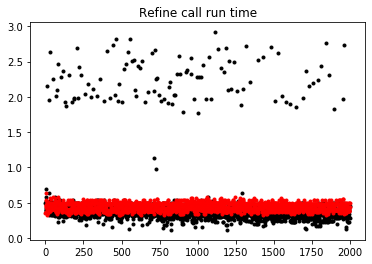

In [8]:
pp.plot(run_timeP2_ML_list,'.k',GmresRunTimeOriginal2,'.r')
pp.title('Refine call run time')

Text(0.5, 1.0, 'Coarse call run time')

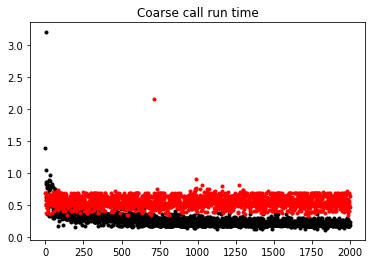

In [9]:
pp.plot(run_timeP1_ML_list,'.k',GmresRunTimeOriginal,'.r')
pp.title('Coarse call run time')

/home/kl748/Research/NERSC/GMRES-Learning/src_dir/util.py:65: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(a[-Window-1:-1])/Window


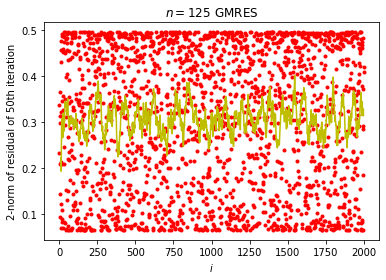

In [10]:
AVG=np.zeros((n_steps,1))
Err_Array=np.asarray(NonML_Err_List)
count=np.arange(0,n_steps)

for j in range(0,n_steps):
    AVG[j]=moving_average(np.asarray(Err_Array[:j]),j)

    
    
pp.plot(count,np.asarray(NonML_Err_List),'.r',count[10:-1],AVG[10:-1],'y')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 50th iteration')
pp.title('$n=125$ GMRES')
pp.savefig('GMRES.png')

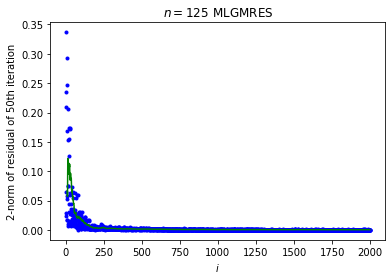

In [11]:
Err_Array_ML=np.asarray(Err_list)
AVGML=np.zeros((n_steps,1))

for j in range(0,n_steps):
    AVGML[j]=moving_average(np.asarray(Err_Array_ML[:j]),j)

pp.plot(count,np.asarray(Err_Array_ML),'.b',count[10:-1],AVGML[10:-1],'g')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 50th iteration')
pp.title('$n=125$ MLGMRES')
pp.savefig('MLGMRES.png')

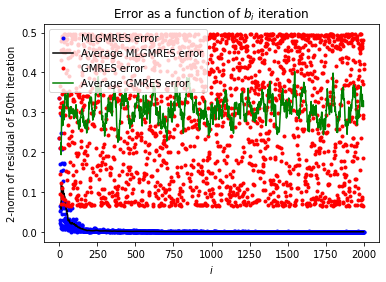

In [12]:
pp.plot(count,Err_Array_ML,'.b',label='MLGMRES error')
pp.plot(count[10:-1],AVGML[10:-1],'k',label='Average MLGMRES error')
pp.plot(count,Err_Array,'.r',label='GMRES error')
pp.plot(count[10:-1],AVG[10:-1],'g',label='Average GMRES error')

pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 50th iteration')
pp.title('Error as a function of $b_i$ iteration ')
pp.legend(loc='best')
pp.savefig('Compare.png')

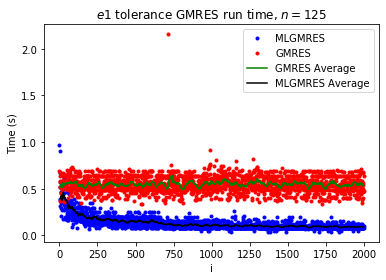

In [13]:
GmresRunTimeOriginal_AVG=np.zeros((n_steps,1))
ML_GMRES_Time_AVG=np.zeros((n_steps,1))


for j in range(0,n_steps):
    GmresRunTimeOriginal_AVG[j]=moving_average(np.asarray(GmresRunTimeOriginal[:j]),j)

for j in range(0,n_steps):
    ML_GMRES_Time_AVG[j]=moving_average(np.asarray(ML_GMRES_Time_list[:j]),j)
    
    
pp.plot(ML_GMRES_Time_list,'.b',label='MLGMRES')
pp.plot(GmresRunTimeOriginal,'.r', label='GMRES')
pp.plot(count[10:-1],GmresRunTimeOriginal_AVG[10:-1],'g', label='GMRES Average')
pp.plot(count[10:-1],ML_GMRES_Time_AVG[10:-1],'k', label='MLGMRES Average')




pp.ylabel('Time (s)')
pp.xlabel('i')
pp.title('$e1$ tolerance GMRES run time, $n=125$')
pp.legend(loc='best')
pp.savefig('Runtime.png')